#Install Dependencies

In [ ]:
!pip install kaggle
!pip install opencv-python

#Import Dependecies

In [ ]:
import kagglehub
import os
import matplotlib.pyplot as plt
import random
import cv2
from collections import defaultdict
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#Download Dataset


In [ ]:
# Download latest version
path = kagglehub.dataset_download("kipshidze/drunk-vs-sober-infrared-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.45M/1.45M [00:00<00:00, 88.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kipshidze/drunk-vs-sober-infrared-image-dataset/versions/5


#Data Inspection

Postoje 4 različite klase uzoraka:

1. Sober State
2. Drunk State 1
3. Drunk State 2
4. Drunk State 2

Korisiti ćemo dvije klase za binarnu klasifikaciju: Sober state i Drunk state

In [ ]:
# available classifiers list in the dataset
available_classifiers_list = ['Sober state', 'Drunk state 1', 'Drunk state 2', 'Drunk state 3']

# classifiers list for binary classification
classifiers_list = ['Sober state', 'Drunk state']

Pregled strukture foldera i broja slika po klasi

Broj slika po klasi:
sober: 122 slika
20mins: 123 slika
40mins: 121 slika
60mins: 120 slika


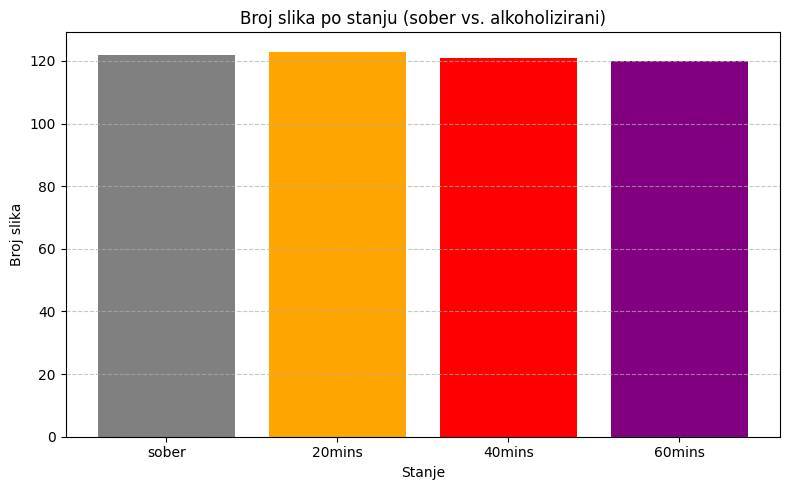

In [ ]:
base_data_path = "/root/.cache/kagglehub/datasets/kipshidze/drunk-vs-sober-infrared-image-dataset/versions/5/drunk_sober_data"
folder_to_label = {
    "sober": 0,
    "20mins": 1,
    "40mins": 2,
    "60mins": 3
}

class_counts = {}

for folder in folder_to_label.keys():
    folder_path = os.path.join(base_data_path, folder)
    image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    class_counts[folder] = len(image_files)

print("Broj slika po klasi:")
for cls, count in class_counts.items():
    print(f"{cls}: {count} slika")

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['gray', 'orange', 'red', 'purple'])
plt.title("Broj slika po stanju (sober vs. alkoholizirani)")
plt.xlabel("Stanje")
plt.ylabel("Broj slika")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Prikaz nekoliko nasumičnih slika iz svake klase

Uzorci iz foldera: sober


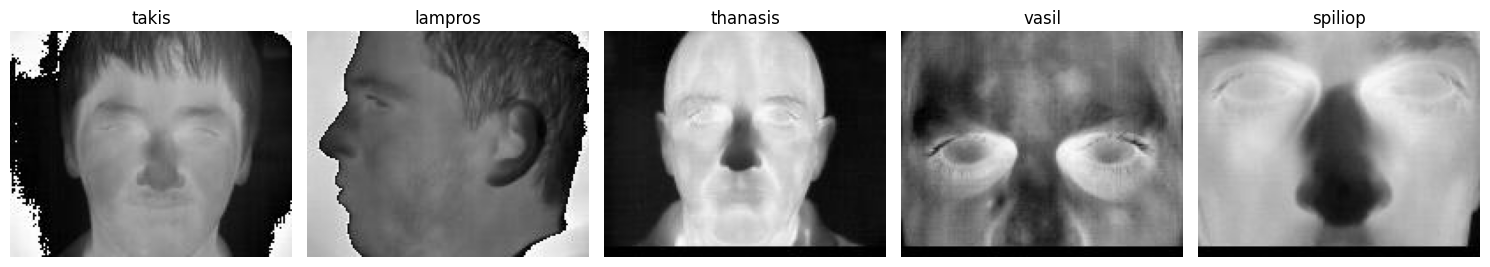

Uzorci iz foldera: 20mins


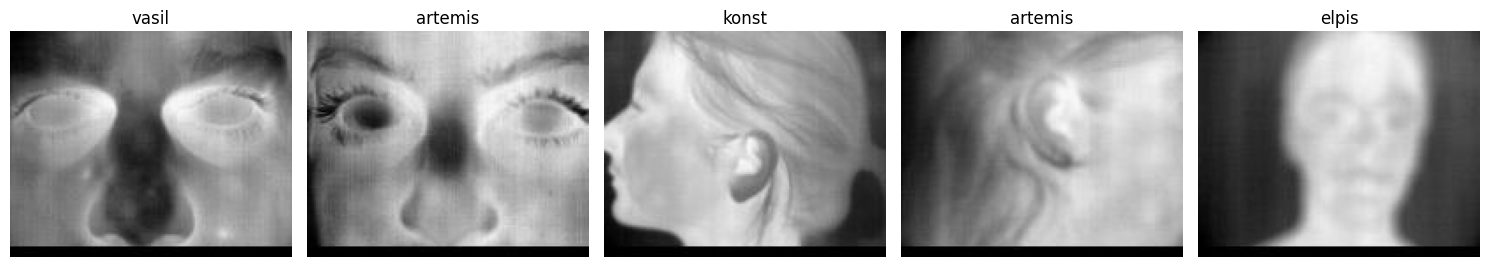

Uzorci iz foldera: 40mins


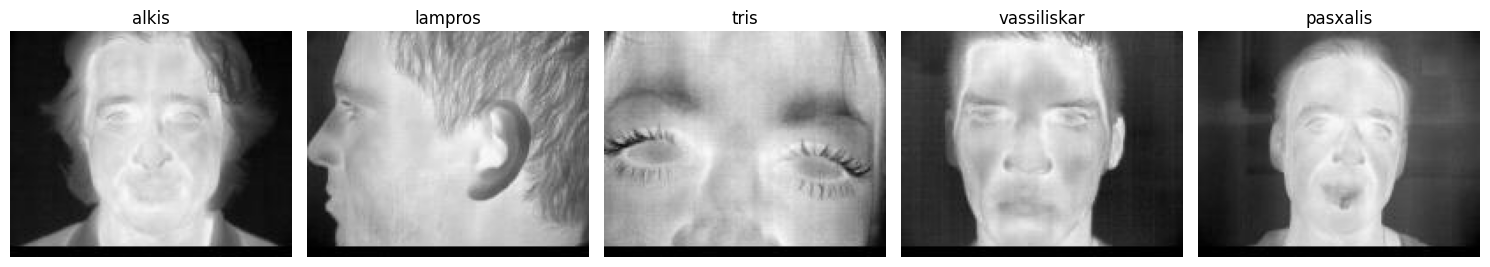

Uzorci iz foldera: 60mins


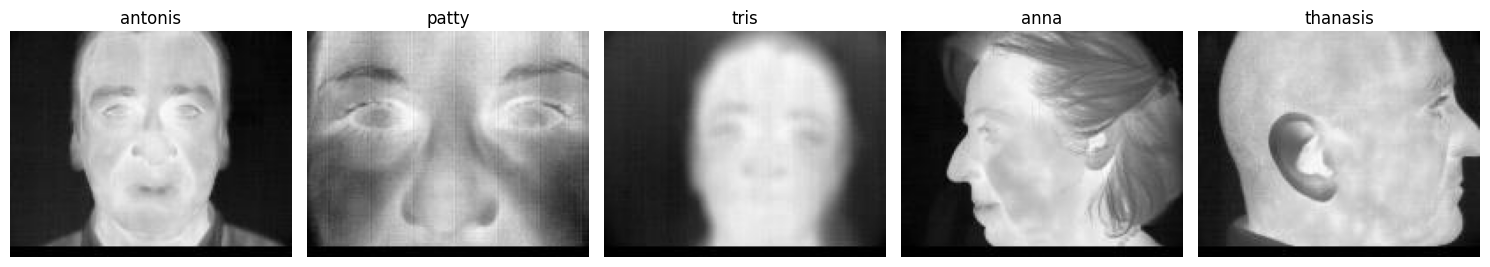

In [ ]:
def show_sample_images(folder_path, num=5):
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    sample_files = random.sample(all_files, num)

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(sample_files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(file.split("_")[1])  # ime osobe
        plt.axis('off')
    plt.tight_layout()
    plt.show()

for folder in folder_to_label.keys():
    print(f"Uzorci iz foldera: {folder}")
    show_sample_images(os.path.join(base_data_path, folder))


Pregled osoba u datasetu i njihovih uzoraka

In [ ]:
person_sample_map = defaultdict(list)

for folder in folder_to_label.keys():
    folder_path = os.path.join(base_data_path, folder)
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):
            person_name = file.split("_")[1]
            person_sample_map[person_name].append(folder)

print("Broj unikatnih osoba:", len(person_sample_map))
print("Primjer: osoba i stanja za koja ima uzorke:")
for i, (person, states) in enumerate(person_sample_map.items()):
    print(f"{person}: {states}")
    if i == 5: break

Broj unikatnih osoba: 41
Primjer: osoba i stanja za koja ima uzorke:
kwstas: ['sober', 'sober', 'sober', '20mins', '20mins', '20mins', '40mins', '40mins', '40mins', '60mins', '60mins', '60mins']
pasxalis: ['sober', 'sober', 'sober', '20mins', '20mins', '20mins', '40mins', '40mins', '40mins', '60mins', '60mins', '60mins']
vassilisA: ['sober', 'sober', 'sober', '20mins', '20mins', '20mins', '40mins', '40mins', '40mins', '60mins', '60mins', '60mins']
thanasis: ['sober', 'sober', 'sober', '20mins', '20mins', '20mins', '40mins', '40mins', '40mins', '60mins', '60mins', '60mins']
christos: ['sober', 'sober', 'sober', '20mins', '20mins', '20mins', '40mins', '40mins', '40mins', '60mins', '60mins', '60mins']
thanos: ['sober', 'sober', 'sober', '20mins', '20mins', '20mins', '40mins', '40mins', '40mins', '60mins', '60mins', '60mins']


Broj instanci po klasama

In [ ]:
base_path = "/root/.cache/kagglehub/datasets/kipshidze/drunk-vs-sober-infrared-image-dataset/versions/5/drunk_sober_data"
class_counts = {}

for cls in os.listdir(base_path):
    cls_path = os.path.join(base_path, cls)
    if os.path.isdir(cls_path):
        images = [f for f in os.listdir(cls_path) if f.endswith(".jpg")]
        class_counts[cls] = len(images)

print("Broj instanci po klasama:", class_counts)

Broj instanci po klasama: {'60mins': 120, '20mins': 123, 'sober': 122, '40mins': 121}


Ukupna veličina dataset-a

In [ ]:
import os

def folder_size(path):
    return sum(os.path.getsize(os.path.join(dp, f)) for dp, _, fn in os.walk(path) for f in fn if f.endswith(".jpg")) / (1024*1024)

size_MB = folder_size(base_path)
print(f"Ukupna veličina podataka: {size_MB:.2f} MB")

Ukupna veličina podataka: 1.34 MB


#Data Preparation

##Priprema Image Dataframe

In [ ]:
import os
import pandas as pd

# Putanja do podataka
base_data_path = "/root/.cache/kagglehub/datasets/kipshidze/drunk-vs-sober-infrared-image-dataset/versions/5/drunk_sober_data"

# Binarna klasifikacija: sve osim 'sober' je 'Drunk state'
folder_to_label = {
    "sober": "Sober state",
    "20mins": "Drunk state",
    "40mins": "Drunk state",
    "60mins": "Drunk state"
}

image_data = []

# Iteracija kroz foldere i slike
for folder, label in folder_to_label.items():
    folder_path = os.path.join(base_data_path, folder)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)
            image_data.append((img_path, label))

# Kreiranje DataFrame-a
img_df = pd.DataFrame(image_data, columns=["Image", "Label"])

# Prikaz
print(img_df["Label"].value_counts())
print(img_df.head())
print(f"\nUkupno slika: {len(img_df)}")

img_df.to_csv("image_df.csv", index=False)

Label
Drunk state    364
Sober state    122
Name: count, dtype: int64
                                               Image        Label
0  /root/.cache/kagglehub/datasets/kipshidze/drun...  Sober state
1  /root/.cache/kagglehub/datasets/kipshidze/drun...  Sober state
2  /root/.cache/kagglehub/datasets/kipshidze/drun...  Sober state
3  /root/.cache/kagglehub/datasets/kipshidze/drun...  Sober state
4  /root/.cache/kagglehub/datasets/kipshidze/drun...  Sober state

Ukupno slika: 486


##Train, Validation, Test split

In [ ]:
val_ratio = 0.10  # 10% za valid_main_df
test_ratio = 0.5  # pola od toga za validaciju, pola za test

# podjela na trening i valid_main
train_df = pd.DataFrame(columns=["Image", "Label"])
valid_main_df = pd.DataFrame(columns=["Image", "Label"])

train_df['Image'], valid_main_df['Image'], train_df['Label'], valid_main_df['Label'] = train_test_split(
    img_df["Image"],
    img_df["Label"],
    test_size=val_ratio,
    stratify=img_df["Label"],
    shuffle=True,
    random_state=42
)

# podjela valid_main na validaciju i test
valid_df = pd.DataFrame(columns=["Image", "Label"])
test_df = pd.DataFrame(columns=["Image", "Label"])

valid_df['Image'], test_df['Image'], valid_df['Label'], test_df['Label'] = train_test_split(
    valid_main_df["Image"],
    valid_main_df["Label"],
    test_size=test_ratio,
    stratify=valid_main_df["Label"],
    shuffle=True,
    random_state=42
)

In [ ]:
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {valid_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (437, 2)
Validation shape: (24, 2)
Test shape: (25, 2)


**Provjera stratifikacije**

Definišemo funkciju za vizualizaciju distribucije stratifikacije

In [ ]:
def distribution_vis_check(train, valid, test):
    '''
    Vizualizacija distribucije klasa u train/valid/test skupovima
    '''
    xdf = [train.index, valid.index, test.index]
    ydf = [train.values, valid.values, test.values]
    labels = ['Train Distribution', 'Validation Distribution', 'Test Distribution']

    fig = plt.figure(figsize=(20,5))
    for i in range(len(xdf)):
        ax = fig.add_subplot(1, len(xdf), i+1)
        sns.barplot(x=xdf[i], y=ydf[i], ax=ax)
        ax.set_title(labels[i], fontsize=16)
        ax.set_xlabel("Klasa")
        ax.set_ylabel("Broj uzoraka")

    plt.tight_layout()
    plt.show()


Rezultat stratifikacije

In [ ]:
print('Startification result:')
print('\nTrain set:\n', train_df['Label'].value_counts())
print('\nValidation set:\n', valid_df['Label'].value_counts())
print('\nTest set:\n', test_df['Label'].value_counts())

Startification result:

Train set:
 Label
Drunk state    327
Sober state    110
Name: count, dtype: int64

Validation set:
 Label
Drunk state    18
Sober state     6
Name: count, dtype: int64

Test set:
 Label
Drunk state    19
Sober state     6
Name: count, dtype: int64


Vizualizacija distrubucije stratifikacije

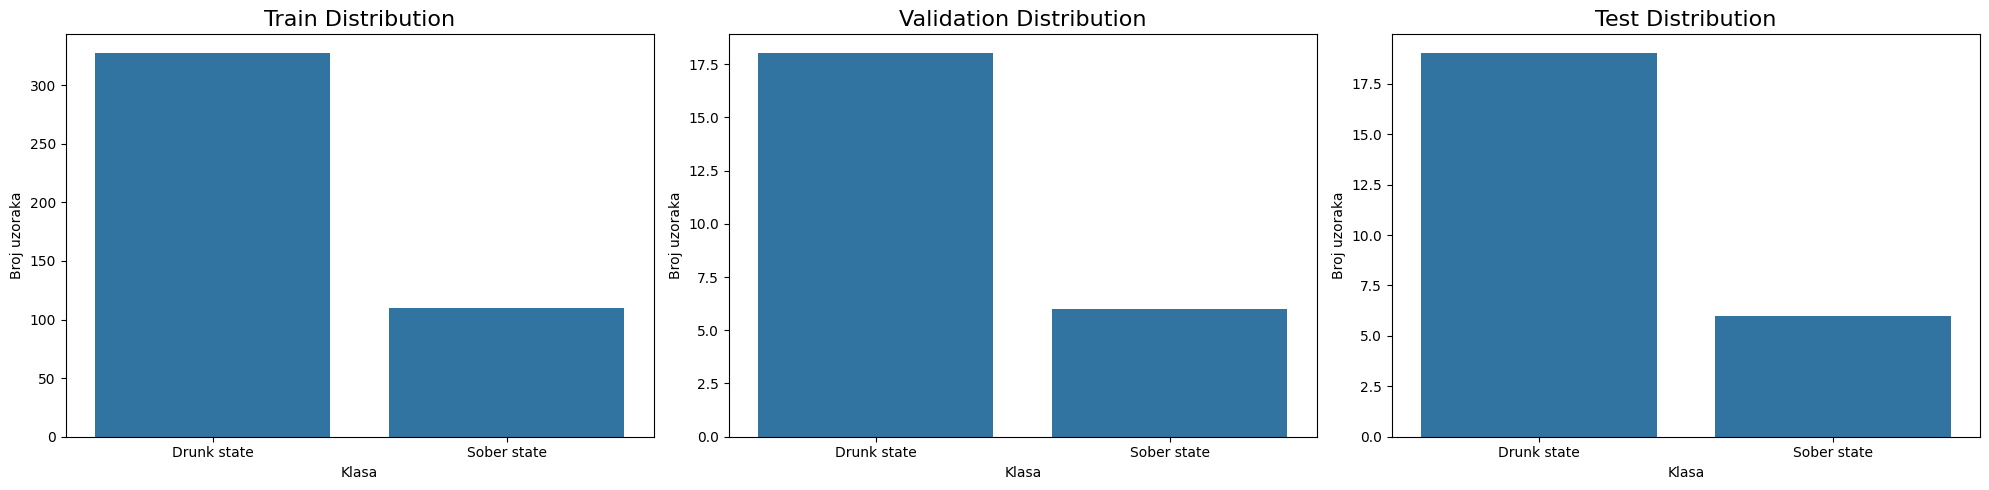

In [ ]:
distribution_vis_check(
    train_df['Label'].value_counts(),
    valid_df['Label'].value_counts(),
    test_df['Label'].value_counts()
)

##Definisanje funkcije za prepocesiranje slika prije treniranja

Konvertuje infracrvene slike u opencv jet colormap i vraća RGB niz sa tipom float32

In [ ]:
def img_preprocess(path):
  # read the infrared image from the given path in unchanged mode
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

  # convert from BGR to RGB format
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # convert to float32
  #img = img.astype(np.float32)

  # convert to jet colormap by converting to uint8 default format that is acceted by opencv 4.5.2
  img = cv2.applyColorMap((img).astype('uint8'), cv2.COLORMAP_JET)

  #img = cv2.normalize(img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = np.float32)
  # convert to float32
  img = img.astype(np.float32)

  # reshape images to (256,256) using keras with 'Bicubic Interpolation
  img = tf.keras.preprocessing.image.smart_resize(img, size=(256,256), interpolation='bicubic')

  # normalize the image, as due to interpolation the pixel value may not lie in the range (0,255)
  # to restrict that we neeed to normalize them so than it can lie within a scale
  img -= img.min()
  img /= (img.max() - img.min())

  return img

Provjera konverzije

Demo image shape: (256, 256, 3)
Demo image datatype: float32
Max, min pixel values: 0.0, 1.0


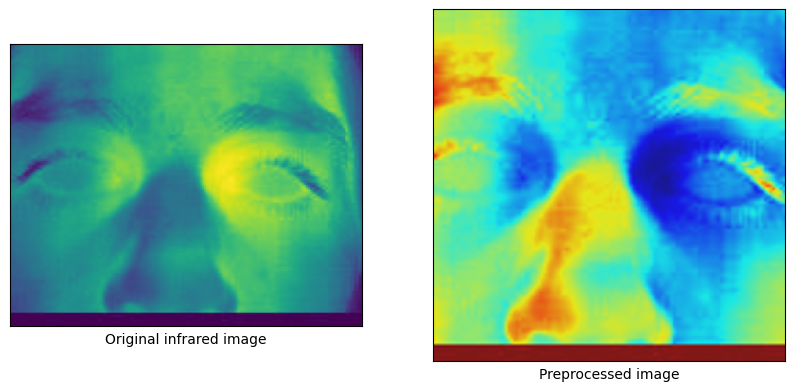

In [ ]:
demo_img_path = '/root/.cache/kagglehub/datasets/kipshidze/drunk-vs-sober-infrared-image-dataset/versions/5/drunk_sober_data/20mins/16_nikos_2_e_M_18_74.jpg'
demo_img = img_preprocess(demo_img_path)

print(f'Demo image shape: {demo_img.shape}')
print(f'Demo image datatype: {demo_img.dtype}')
print(f'Max, min pixel values: {demo_img.min()}, {demo_img.max()}')

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))

fig.add_subplot(121)
plt.imshow(cv2.imread(demo_img_path, cv2.IMREAD_UNCHANGED))
plt.xlabel('Original infrared image')
plt.xticks([])
plt.yticks([])

fig.add_subplot(122)
plt.imshow(demo_img)
plt.xlabel('Preprocessed image')
plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
id_list = [i for i in range(len(classifiers_list))]

#labeliranje
label_dict = dict(zip(classifiers_list, id_list))
print(f'Classifiers dictionary:\n{label_dict}')


Classifiers dictionary:
{'Sober state': 0, 'Drunk state': 1}


##Priprema ulazno-izlaznih parova za treniranje, validaciju i testiranje

In [ ]:
def dataset_prep(image_df):
  # input image array list
  x = []
  # output label list
  y = []
  for img_path, label in zip(image_df.loc[:,'Image'], image_df.loc[:,'Label']):
    # image conversion
    img = img_preprocess(img_path)
    # image append to list
    x.append(img)
    # label id for sparse categorical crossentropy
    label_id = label_dict[label]
    # append label_id
    y.append(label_id)

  # returns input, label list
  return x, y

In [ ]:
x_train, y_train = dataset_prep(train_df)
x_valid, y_valid = dataset_prep(valid_df)
x_test, y_test = dataset_prep(test_df)

##Pretvaranje setova za treniranje, validaciju i test u NumPy niz

In [ ]:
# train data conversion
x_train, y_train = np.array(x_train), np.array(y_train, dtype=np.int32)
# valid data conversion
x_valid, y_valid = np.array(x_valid), np.array(y_valid, dtype=np.int32)
# test data conversion
x_test, y_test = np.array(x_test), np.array(y_test, dtype=np.int32)

In [ ]:
print(f'Train shape, data-type :\n{x_train.shape}, {x_train.dtype}\n{y_train.shape}, {y_train.dtype}')
print(f'Validation shape, data-type :\n{x_valid.shape}, {x_valid.dtype}\n{y_valid.shape}, {y_valid.dtype}')
print(f'Test shape, data-type :\n{x_test.shape}, {x_test.dtype}\n{y_test.shape}, {y_test.dtype}')

Train shape, data-type :
(437, 256, 256, 3), float32
(437,), int32
Validation shape, data-type :
(24, 256, 256, 3), float32
(24,), int32
Test shape, data-type :
(25, 256, 256, 3), float32
(25,), int32


#CNN Model Building

In [ ]:
# input image shape
input_shape = (256,256,3)
def model(input_shape, num_classes):
  inputs = tf.keras.layers.Input(shape = input_shape)

  x = tf.keras.layers.Conv2D(filters = 16, kernel_size=(3,3), activation='relu', strides=(1,1))(inputs)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu', strides=(1,1))(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (2,2))(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1000, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate = 0.3)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  return tf.keras.Model(inputs = inputs, outputs = output)

model = model(input_shape, 1)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │     1,153,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,186,833 (4.53 MB)

 Trainable params: 1,186,833 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

Trening konfiguracija

In [ ]:
learning_rate = 0.001
epochs = 30
loss_fn = tf.keras.losses.BinaryCrossentropy()
optim = tf.keras.optimizers.Adam(learning_rate = learning_rate)

Definisanje metrike

In [ ]:
METRICS = [
           tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'),
           tf.keras.metrics.BinaryAccuracy(name='acc'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc'),
           tf.keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

Kompajliranje modela

In [ ]:
model.compile(optimizer=optim, loss=loss_fn, metrics=METRICS)

Treniranje modela

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_valid, y_valid)
)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - acc: 0.7248 - auc: 0.5173 - fn: 9.0000 - fp: 59.6667 - loss: 0.6771 - prc: 0.7537 - precision: 0.7679 - recall: 0.9175 - tn: 6.0000 - tp: 177.7333 - val_acc: 0.7500 - val_auc: 0.4352 - val_fn: 0.0000e+00 - val_fp: 6.0000 - val_loss: 0.6369 - val_prc: 0.7484 - val_precision: 0.7500 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 18.0000
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - acc: 0.7538 - auc: 0.4953 - fn: 0.0000e+00 - fp: 62.3333 - loss: 0.5854 - prc: 0.7618 - precision: 0.7538 - recall: 1.0000 - tn: 0.0000e+00 - tp: 190.0667 - val_acc: 0.7500 - val_auc: 0.5185 - val_fn: 0.0000e+00 - val_fp: 6.0000 - val_loss: 0.5671 - val_prc: 0.7535 - val_precision: 0.7500 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_tp: 18.0000
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - acc: 0.7324 - auc: 0.5289 - fn: 0.0000e+00 - fp: 66.6000 - loss: 0.5833 - prc: 0.7701 - precision: 0.7324 - recall: 1.0000 - tn: 0.0000e+00 - tp: 185.80

Vizualizacija trening metrika

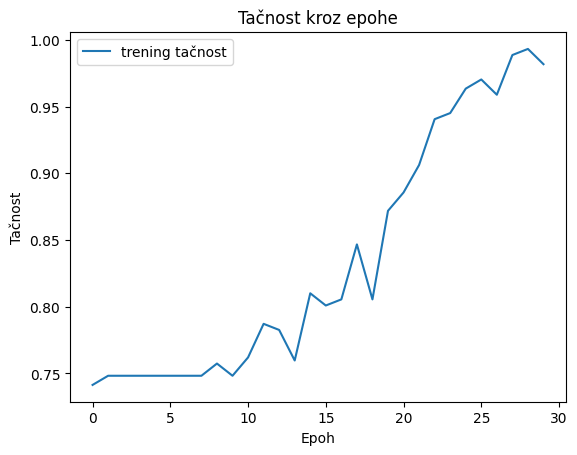

In [ ]:
plt.plot(history.history['acc'], label='trening tačnost')
plt.title('Tačnost kroz epohe')
plt.xlabel('Epoh')
plt.ylabel('Tačnost')
plt.legend()
plt.show()


Funkcija za evaluaciju modela

In [ ]:
def plot_metrics(model, x, y, p=0.25):
  # get model predictions
  y_pred = model.predict(x)
  # obtains predictions based on robability
  predictions = y_pred>p
  print(f'Classification Report for the model\n{metrics.classification_report(y, predictions)}\n')
  print(f'\nClassification accuracy: {metrics.accuracy_score(y, predictions)*100: 0.2f}\n')
  print('Confusion matrix')
  sns.heatmap(confusion_matrix(y, predictions), annot = True)
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Classification Report for the model
              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.77      0.89      0.83        19

    accuracy                           0.72        25
   macro avg       0.55      0.53      0.53        25
weighted avg       0.67      0.72      0.68        25



Classification accuracy:  72.00

Confusion matrix


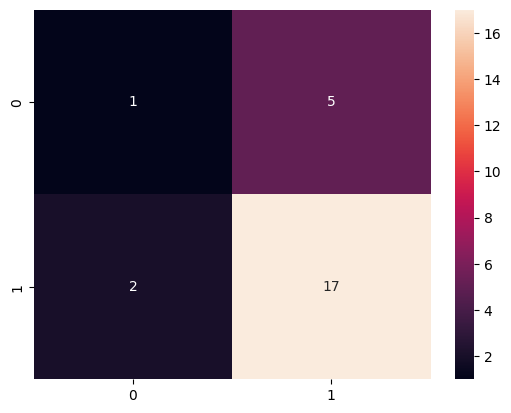

In [ ]:
# Evaluacija na test skupu
plot_metrics(model, x_test, y_test)